0.5663409708295999
69861.1612078909
16006.635137323432


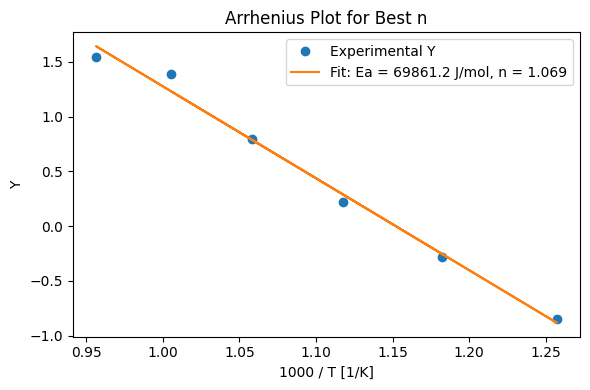

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress

# === INPUT DATA ===
dP_CH4 = 0.0001

T_data = np.array([845.79, 945.17, 1045.52, 795.41, 894.75, 994.56])  # Temperature in K
P_CH4_in = 0.2029 # bar
P_H2O_in = 0.6087 # bar
P_CH4_out_Data = np.array([0.1018, 0.0419, 0.0144, 0.1350, 0.0718, 0.0192])  # bar
V_R = 2343.7 * 10**-9  # Reactor volume in m^3
total_flow = (16.16 + 10 + 48.48 + 5)/60000000 #m^3/s
S_V = total_flow/V_R  # 1/sec
print(S_V)
R = 8.314  # J/mol/K

P_H2_in = 0.125565 # bar
P_CO_in = 0
P_Ar = 1 - (P_CH4_in + P_H2O_in + P_H2_in + P_CO_in)

Ptotold = 1 # bar

# === EQUILIBRIUM CONSTANT FUNCTION ===
def K_eq(T):
    return (101325/100000)**2 * np.exp(-26830/T + 30.114)

# === INTEGRAL FUNCTION ===
def integral_I(n, T, P_CH4_out):
    sum = 0
    #adjust these to get the data when you are done
    P_CH4 = P_CH4_in
    P_H2O = P_H2O_in
    P_H2 = P_H2_in
    P_CO = P_CO_in

    while P_CH4 > P_CH4_out:
        sum = sum + dP_CH4/((P_CH4**n) * (P_H2O**n) - 1/(K_eq(T)**n) * (P_CO**n) * (P_H2**(3*n)))
        P_CH4 = P_CH4 - dP_CH4
        P_H2O = P_H2O - dP_CH4
        P_H2 = P_H2 + 3*dP_CH4
        P_CO = P_CO + dP_CH4

        #pressure normalization
        Ptotnew = P_CH4 + P_H2O + P_H2 + P_CO + P_Ar
        P_CH4 = P_CH4*Ptotold/Ptotnew
        P_H2O = P_H2O*Ptotold/Ptotnew
        P_H2 = P_H2*Ptotold/Ptotnew
        P_CO = P_CO*Ptotold/Ptotnew
    return sum

# === SCAN n VALUES AND FIT ===
n_range = np.linspace(0.5, 2.05, 50)
results = []

for n in n_range:
    I_n = np.array([integral_I(n, T, P_CH4_out) for T, P_CH4_out in zip(T_data, P_CH4_out_Data)])
    expY = (S_V * I_n)
    Y = np.log(expY)
    inv_T = 1 / T_data
    slope, intercept, r_value, _, _ = linregress(inv_T, Y)
    Ea = -slope * R
    results.append({
        'n': n,
        'Ea_Jmol': Ea,
        'slope': slope,
        'intercept': intercept,
        'r_squared': r_value**2
    })

# === SELECT BEST n ===
best_result = max(results, key=lambda d: d['r_squared'])
best_n = best_result['n']
best_slope = best_result['slope']
best_intercept = best_result['intercept']
best_Ea = best_result['Ea_Jmol']
print(best_Ea)
print(np.exp(best_intercept))

# === PLOT BEST FIT ===
I_best = np.array([integral_I(best_n, T, P_CH4_out) for T, P_CH4_out in zip(T_data, P_CH4_out_Data)])
expY_best = (S_V * I_best)
Y_best = np.log(expY_best)
inv_T = 1 / T_data
Y_fit = best_slope * inv_T + best_intercept

plt.figure(figsize=(6, 4))
plt.plot(inv_T*1000, Y_best, 'o', label='Experimental Y')
plt.plot(inv_T*1000, Y_fit, '-', label=f'Fit: Ea = {best_Ea:.1f} J/mol, n = {best_n:.3f}')
plt.xlabel('1000 / T [1/K]')
plt.ylabel('Y')
plt.title('Arrhenius Plot for Best n')
plt.legend()
plt.grid(False)
plt.tight_layout()
plt.show()